In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm

import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import Angle

import pickle
import pandas as pd

coord.galactocentric_frame_defaults.set('v4.0')
import galstreams
import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic
from gala.dynamics.nbody import DirectNBody
import gala.integrate as gi

%matplotlib inline
%config InlineBackend.figure_format='retina'

from helpers.SimulationAnalysis import SimulationAnalysis, iterTrees
from helpers.SimulationAnalysis import readHlist

In [4]:
gsr = coord.Galactocentric()
mwsts = galstreams.MWStreams(verbose=False, implement_Off=False)

Initializing galstreams library from master_log... 


In [5]:
#Path to simulation data
path_to_data = ''

#Halo properties to load; see Section 2.4 of https://arxiv.org/abs/2008.08591 for info on Rockstar fields 
fields = ['scale','id', 'upid', 'pid', 'mvir', 'mpeak', 'rvir', 'RVmax', 'rs', 'vmax', 'vpeak', 'x', 'y', 'z', 'vx', 'vy', 'vz',
          'M200c', 'depth_first_id','scale_of_last_MM']

#Load z = 0 halo list for Halo416_16K
halos_z0 = readHlist(path_to_data+'hlist_1.00000.list',fields=fields)
MW_analog = halos_z0[np.argmax(halos_z0['mvir'])]

subhalos_z0 = halos_z0[halos_z0['upid']==MW_analog['id']]
LMC_analog = subhalos_z0[np.argmax(subhalos_z0['mvir'])]


#Reading in data from dm particles
t = Table.read('snapshot_now.fits')

# ind_lmc = subhalos_z0['pid']==LMC_analog['id']
ind_lmc = np.argmax(subhalos_z0['mvir'])


In [6]:
#USED TO READ IN NEW DATA
data_complete_updated = pd.read_csv('20220727_Complete_Data_Subhalo_to_Stream_Distance.csv') 
data_complete_updated

,Name,Subhalo_0 (kpc),Subhalo_1 (kpc),Subhalo_2 (kpc),Subhalo_3 (kpc),Subhalo_4 (kpc),Subhalo_5 (kpc),Subhalo_6 (kpc),Subhalo_7 (kpc),Subhalo_8 (kpc),...,Subhalo_1062 (kpc),Subhalo_1063 (kpc),Subhalo_1064 (kpc),Subhalo_1065 (kpc),Subhalo_1066 (kpc),Subhalo_1067 (kpc),Subhalo_1068 (kpc),Subhalo_1069 (kpc),Subhalo_1070 (kpc),Subhalo_1071 (kpc)
0,20.0-1-M18,96.125488,110.203072,279.527270,159.543109,109.367049,283.024522,97.380167,188.192065,228.925626,...,126.474416,100.578684,134.660640,129.086641,142.694416,136.658615,102.594118,213.389389,219.224383,133.921979
1,300S-F18,103.860247,126.150558,279.966654,189.463545,91.733697,297.547259,131.253776,157.874095,191.563736,...,163.958572,118.471081,107.898629,121.266635,119.377227,153.154252,71.494913,233.095093,193.054959,118.829699
2,AAU-AliqaUma-L21,91.992972,108.765353,293.615754,170.528202,87.575430,310.779784,111.884931,185.923846,226.253138,...,136.224703,98.895998,135.223542,152.709911,150.034819,139.008683,110.234675,204.850545,222.303374,113.448718
3,AAU-ATLAS-L21,87.703690,106.826566,295.027747,171.076113,83.143622,305.444755,113.115563,181.948509,219.738178,...,139.818407,97.737481,124.747662,144.363483,146.419776,136.478471,103.246197,210.004051,211.779893,108.568121
4,Acheron-G09,101.622110,121.423538,278.510475,181.632687,97.141819,298.515880,121.878820,169.437490,206.895195,...,151.916905,112.772059,122.072018,129.026489,127.439885,149.234252,84.626027,222.871240,207.749541,123.602724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Turranburra-S19,81.087141,103.988262,304.733076,177.326375,68.124787,307.753535,124.455073,177.884530,212.855773,...,156.754588,96.258997,111.612846,143.752015,148.482678,133.502412,101.904439,220.316436,198.855692,93.858335
93,Vid-I21,84.114777,102.701333,297.596093,169.369783,80.346689,305.388530,113.432755,183.151746,220.658078,...,141.416507,93.429482,124.022964,145.017979,148.211159,132.852285,104.627233,212.552947,211.098083,105.097458
94,Wambelong-S18,86.321059,107.879102,296.305530,174.910600,80.603944,297.920599,118.985016,175.205697,210.500435,...,152.803405,99.823849,112.669964,132.391588,140.150885,136.220672,93.273018,227.303111,199.442405,106.108126
95,Willka_Yaku-S18,68.360500,86.284744,313.550614,153.068346,80.748331,291.442408,99.410329,198.935694,233.561456,...,134.802541,77.317593,120.780858,141.814270,163.484709,115.481162,115.743271,230.517964,206.978448,99.864927


In [7]:
#CREATING A DICTIONARY THAT STORES THE ROWS 
rows = {}
for i in range(data_complete_updated.to_numpy().shape[0]):
     rows['row'+str(i)]= data_complete_updated.to_numpy()[i][1:]
rows

{'row0': array([96.12548817795384, 110.20307164380088, 279.52727010946927, ...,
        213.38938866040908, 219.2243825781225, 133.92197920883078],
       dtype=object),
 'row1': array([103.86024678170617, 126.15055811929788, 279.9666540488493, ...,
        233.0950929516952, 193.0549589606832, 118.82969896897885],
       dtype=object),
 'row2': array([91.99297200538928, 108.76535293158312, 293.61575428450675, ...,
        204.85054500614575, 222.3033739461773, 113.44871818465366],
       dtype=object),
 'row3': array([87.70368971049726, 106.82656590543296, 295.0277471293773, ...,
        210.00405116179263, 211.77989274888796, 108.5681209729958],
       dtype=object),
 'row4': array([101.62210972425518, 121.42353838022056, 278.51047501077545, ...,
        222.87123996325664, 207.74954115812267, 123.60272385490906],
       dtype=object),
 'row5': array([102.108465041713, 124.49499152942968, 273.2656488337897, ...,
        218.9668648301724, 199.6336488890555, 116.30652145099948],
     

In [8]:
h = 0.7
ts = Table(subhalos_z0)
for comp in ['x', 'y', 'z']:
    ts[comp] = ((ts[comp] - MW_analog[comp])*u.Mpc/h).to(u.kpc)
for comp in ['vx', 'vy', 'vz']:
    ts[comp] = (ts[comp] - MW_analog[comp])*u.km/u.s

In [9]:
ind_massive = (ts['mvir'] > 10**7)
len(ts['mvir'][ind_massive])

1072

In [10]:
c = coord.Galactocentric(x=ts['x'][ind_massive], y=ts['y'][ind_massive], z=ts['z'][ind_massive],
                         v_x=ts['vx'][ind_massive], v_y=ts['vy'][ind_massive], v_z=ts['vz'][ind_massive])
ceq = c.transform_to(coord.ICRS())

ceq_lmc = coord.ICRS(ra=78.76*u.deg, dec=-69.19*u.deg, distance=(10**(0.2*18.50+1)*u.pc).to(u.kpc), 
                     radial_velocity=262.2*u.km/u.s, pm_ra_cosdec=1.91*u.mas/u.yr, pm_dec=0.229*u.mas/u.yr)
c_lmc = ceq_lmc.transform_to(coord.Galactocentric())

In [11]:
vsim = np.array([c.x.value[ind_lmc], c.y.value[ind_lmc], c.z.value[ind_lmc]]) #this is the u vector 
vsim = vsim / np.linalg.norm(vsim)

vtrue = np.array([c_lmc.x.value, c_lmc.y.value, c_lmc.z.value]) #this is the v vector 
vtrue = vtrue / np.linalg.norm(vtrue)

vpole = np.cross(vsim, vtrue)
vpole = vpole / np.linalg.norm(vpole)

In [12]:
theta = np.arccos(np.dot(vsim,vtrue)/(np.linalg.norm(vsim)*np.linalg.norm(vtrue)))

In [13]:
#ROTATION MATRIX
R = np.array([[np.cos(theta) + vpole[0]**2*(1-np.cos(theta)),
              vpole[0]*vpole[1]*(1-np.cos(theta)) - vpole[2]*np.sin(theta),
              vpole[0]*vpole[2]*(1-np.cos(theta)) + vpole[1]*np.sin(theta)],
             [vpole[1]*vpole[0]*(1-np.cos(theta)) + vpole[2]*np.sin(theta),
              np.cos(theta) + vpole[1]**2*(1-np.cos(theta)),
              vpole[1]*vpole[2]*(1-np.cos(theta)) - vpole[0]*np.sin(theta)],
             [vpole[2]*vpole[0]*(1-np.cos(theta)) - vpole[1]*np.sin(theta),
              vpole[2]*vpole[1]*(1-np.cos(theta)) + vpole[0]*np.sin(theta),
              np.cos(theta) + vpole[2]**2*(1-np.cos(theta))]])

In [14]:
trot = Table(subhalos_z0[ind_massive])
N = len(trot)
trot['x'] = np.zeros(N)#*u.kpc
trot['y'] = np.zeros(N)#*u.kpc
trot['z'] = np.zeros(N)#*u.kpc

for i in range(N):
    temp_vec = np.array([ts['x'][ind_massive][i], ts['y'][ind_massive][i], ts['z'][ind_massive][i]])
    rot_vec = np.matmul(R, temp_vec)
    
    trot['x'][i] = rot_vec[0]#*u.kpc
    trot['y'][i] = rot_vec[1]#*u.kpc
    trot['z'][i] = rot_vec[2]#*u.kpc

In [15]:
#This is the radius from the center at which the maximum velocity occurs
trot['rs'] = (trot['RVmax'])/2.163

In [16]:
r_peri = dict(LMS_1=10.8, Gjoll=8.5, Leiptr=12.3, Hrid=1.1, Pal5=6.9, Orphan=15.6, 
             Gaia_1=8.2, Fimbulthul=2.4, Ylgr=11.5, Fjorm=9.1, Kshir=13.4, Cetus=14.7,
             Svol=5.9, Gunnthra=4.2, Slidr=8.7, M92=3.0, NGC_6397=3.4, NGC_3201=8.5,
             Ophiuchus=3.9, Atlas=11.7, C_7=3.5, C_3=5.7, Palca=10.8, Sylgr=8.7,
             Gaia_6=6.0, Gaia_9=8.7, Gaia_10=4.3, Gaia_12=18.5, Indus=12.6, Jhelum=8.7,
             Phoenix=11.7, NGC5466=4.8, M5=3.4, C_20=20.8, NGC7089=2.9, C_19=9.3,
             Elqui=12.1, Chenab=22.0, AliqaUma=11.6, Phlegethon=5.5, GD_1=14.1)
r_peri

{'LMS_1': 10.8,
 'Gjoll': 8.5,
 'Leiptr': 12.3,
 'Hrid': 1.1,
 'Pal5': 6.9,
 'Orphan': 15.6,
 'Gaia_1': 8.2,
 'Fimbulthul': 2.4,
 'Ylgr': 11.5,
 'Fjorm': 9.1,
 'Kshir': 13.4,
 'Cetus': 14.7,
 'Svol': 5.9,
 'Gunnthra': 4.2,
 'Slidr': 8.7,
 'M92': 3.0,
 'NGC_6397': 3.4,
 'NGC_3201': 8.5,
 'Ophiuchus': 3.9,
 'Atlas': 11.7,
 'C_7': 3.5,
 'C_3': 5.7,
 'Palca': 10.8,
 'Sylgr': 8.7,
 'Gaia_6': 6.0,
 'Gaia_9': 8.7,
 'Gaia_10': 4.3,
 'Gaia_12': 18.5,
 'Indus': 12.6,
 'Jhelum': 8.7,
 'Phoenix': 11.7,
 'NGC5466': 4.8,
 'M5': 3.4,
 'C_20': 20.8,
 'NGC7089': 2.9,
 'C_19': 9.3,
 'Elqui': 12.1,
 'Chenab': 22.0,
 'AliqaUma': 11.6,
 'Phlegethon': 5.5,
 'GD_1': 14.1}

In [17]:
r_apo = dict(LMS_1=20.6, Gjoll=27.4, Leiptr=45.1, Hrid=22.0, Pal5=15.8, Orphan=41.2, 
             Gaia_1=67.6, Fimbulthul=7.2, Ylgr=20.7, Fjorm=29.1, Kshir=16.0, Cetus=35.9,
             Svol=10.0, Gunnthra=7.2, Slidr=32.3, M92=10.7, NGC_6397=6.4, NGC_3201=30.5,
             Ophiuchus=14.2, Atlas=32.4, C_7=21.0, C_3=10.0, Palca=16.5, Sylgr=24.6,
             Gaia_6=9.5, Gaia_9=20.8, Gaia_10=37.7, Gaia_12=194.3, Indus=18.9, Jhelum=24.5,
             Phoenix=18.1, NGC5466=33.7, M5=24.8, C_20=58.5, NGC7089=14.7, C_19=21.6,
             Elqui=54.0, Chenab=81.0, AliqaUma=31.9, Phlegethon=22.1, GD_1=23.0)
r_apo

{'LMS_1': 20.6,
 'Gjoll': 27.4,
 'Leiptr': 45.1,
 'Hrid': 22.0,
 'Pal5': 15.8,
 'Orphan': 41.2,
 'Gaia_1': 67.6,
 'Fimbulthul': 7.2,
 'Ylgr': 20.7,
 'Fjorm': 29.1,
 'Kshir': 16.0,
 'Cetus': 35.9,
 'Svol': 10.0,
 'Gunnthra': 7.2,
 'Slidr': 32.3,
 'M92': 10.7,
 'NGC_6397': 6.4,
 'NGC_3201': 30.5,
 'Ophiuchus': 14.2,
 'Atlas': 32.4,
 'C_7': 21.0,
 'C_3': 10.0,
 'Palca': 16.5,
 'Sylgr': 24.6,
 'Gaia_6': 9.5,
 'Gaia_9': 20.8,
 'Gaia_10': 37.7,
 'Gaia_12': 194.3,
 'Indus': 18.9,
 'Jhelum': 24.5,
 'Phoenix': 18.1,
 'NGC5466': 33.7,
 'M5': 24.8,
 'C_20': 58.5,
 'NGC7089': 14.7,
 'C_19': 21.6,
 'Elqui': 54.0,
 'Chenab': 81.0,
 'AliqaUma': 31.9,
 'Phlegethon': 22.1,
 'GD_1': 23.0}

In [18]:
r_peri.values()

dict_values([10.8, 8.5, 12.3, 1.1, 6.9, 15.6, 8.2, 2.4, 11.5, 9.1, 13.4, 14.7, 5.9, 4.2, 8.7, 3.0, 3.4, 8.5, 3.9, 11.7, 3.5, 5.7, 10.8, 8.7, 6.0, 8.7, 4.3, 18.5, 12.6, 8.7, 11.7, 4.8, 3.4, 20.8, 2.9, 9.3, 12.1, 22.0, 11.6, 5.5, 14.1])

In [19]:
subhalo_dist=np.sqrt(trot['x']**2+trot['y']**2+trot['z']**2)
#subhalo_dist

In [20]:
r_peri['Gaia_1']

8.2

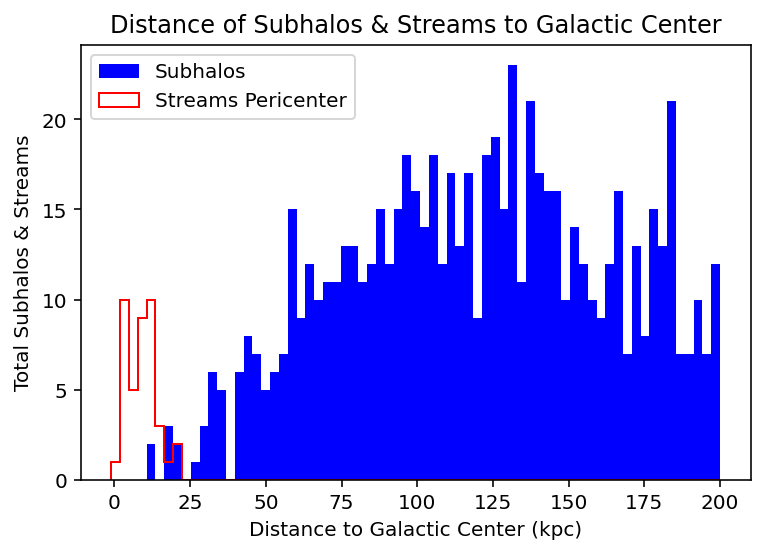

In [21]:
plt.figure()
plt.hist(subhalo_dist, bins=np.linspace(-1,200,70), color='blue', label='Subhalos'); 
plt.hist(r_peri.values(),bins=np.linspace(-1,200,70), color='red', histtype='step', label='Streams Pericenter')
plt.title('Distance of Subhalos & Streams to Galactic Center') 
plt.xlabel('Distance to Galactic Center (kpc)')
plt.ylabel('Total Subhalos & Streams')
plt.legend(loc='best')
plt.savefig('Histograms/Subhalos_Histograms_Peri/Subhalos_Histograms_Peri.png', transparent=False)

In [22]:
ind_massive_lmc = (np.argmax(trot['mvir']))

lmc_dist=np.sqrt(trot['x'][ind_massive_lmc]**2+trot['y'][ind_massive_lmc]**2+trot['z'][ind_massive_lmc]**2)
lmc_dist

100.19523134839284

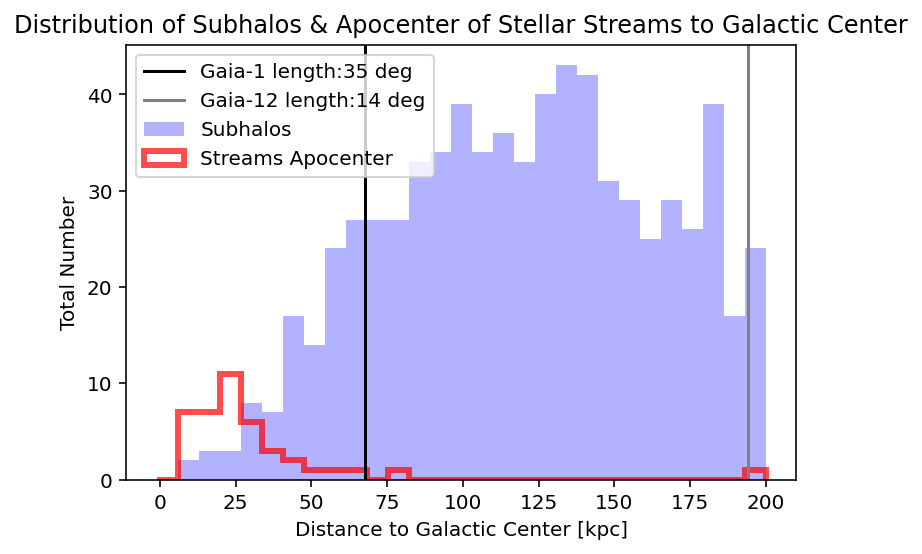

In [23]:
plt.figure()
plt.hist(subhalo_dist, bins=np.linspace(-1,200,30), color='blue', alpha=0.3, label='Subhalos'); 
plt.hist(r_apo.values(),bins=np.linspace(-1,200,30), color='red', alpha=0.7,
         histtype='step', linewidth=3, label='Streams Apocenter')
#plt.axvline(lmc_dist, color='orange', label = 'LMC Analog')
plt.axvline(r_apo['Gaia_1'], color='black', label = "Gaia-1 length:{:.0f} deg".format(mwsts['Gaia-1-I21'].length.deg))
#plt.axvline(r_apo['Chenab'],color='magenta', label = "Orphan length:{:.0f} deg".format(mwsts['Orphan-K19'].length.deg))
plt.axvline(r_apo['Gaia_12'],color='grey', label = "Gaia-12 length:{:.0f} deg".format(mwsts['Gaia-12-I21'].length.deg))
plt.title('Distribution of Subhalos & Apocenter of Stellar Streams to Galactic Center') 
plt.xlabel('Distance to Galactic Center [kpc]')
plt.ylabel('Total Number')
plt.legend(loc='best')
plt.savefig('Histograms/Subhalos_Histograms_Apo/Subhalos_Histograms_Apo.png', transparent=False, dpi=200)
#plt.close(fig)

In [24]:
ind_massive_lmc_new = (np.argmax(ts['mvir']))

lmc_dist_new=np.sqrt(ts['x'][ind_massive_lmc_new]**2+ts['y'][ind_massive_lmc_new]**2+ts['z'][ind_massive_lmc_new]**2)
lmc_dist_new

100.19523134839281

In [25]:
np.max(r_apo.values())

dict_values([20.6, 27.4, 45.1, 22.0, 15.8, 41.2, 67.6, 7.2, 20.7, 29.1, 16.0, 35.9, 10.0, 7.2, 32.3, 10.7, 6.4, 30.5, 14.2, 32.4, 21.0, 10.0, 16.5, 24.6, 9.5, 20.8, 37.7, 194.3, 18.9, 24.5, 18.1, 33.7, 24.8, 58.5, 14.7, 21.6, 54.0, 81.0, 31.9, 22.1, 23.0])

In [26]:
mwsts.keys()

dict_keys(['20.0-1-M18', '300S-F18', 'AAU-AliqaUma-L21', 'AAU-ATLAS-L21', 'Acheron-G09', 'ACS-R21', 'Alpheus-G13', 'Aquarius-W11', 'C-19-I21', 'C-4-I21', 'C-5-I21', 'C-7-I21', 'C-8-I21', 'C-9-I21', 'Cetus-New-Y21', 'Cetus-Palca-T21', 'Cetus-Y13', 'Cocytos-G09', 'Corvus-M18', 'Elqui-S19', 'Eridanus-M17', 'Gaia-1-I21', 'Gaia-10-I21', 'Gaia-11-I21', 'Gaia-12-I21', 'Gaia-2-I21', 'Gaia-3-M18', 'Gaia-4-M18', 'Gaia-5-M18', 'Gaia-6-I21', 'Gaia-7-I21', 'Gaia-8-I21', 'Gaia-9-I21', 'GD-1-I21', 'Gunnthra-I21', 'Hermus-G14', 'Hrid-I21', 'Hyllus-G14', 'Indus-S19', 'Jet-F22', 'Jhelum-a-B19', 'Jhelum-b-B19', 'Kshir-I21', 'Kwando-G17', 'Leiptr-I21', 'Lethe-G09', 'LMS1-Y20', 'M2-I21', 'M30-S20', 'M5-G19', 'M68-P19', 'M92-I21', 'Molonglo-G17', 'Monoceros-R21', 'Murrumbidgee-G17', 'NGC1261-I21', 'NGC1851-I21', 'NGC2298-I21', 'NGC288-I21', 'NGC3201-P21', 'NGC5466-G06', 'NGC6362-S20', 'NGC6397-I21', 'OmegaCen-I21', 'Ophiuchus-C20', 'Orinoco-G17', 'Orphan-K19', 'Pal13-S20', 'Pal15-M17', 'Pal5-PW19', 'Palca-S

In [27]:
mwsts['Gaia-1-I21'].length

<Angle 34.57025167 deg>

In [28]:
mwsts['Orphan-K19'].length

<Angle 230.56220929 deg>

In [29]:
mwsts['Gaia-12-I21'].length

<Angle 13.74791194 deg>

In [30]:
(MW_analog['RVmax'])/2.163/h

57.59038459702753

In [31]:
MW_analog['rs']/h

26.877141680036274

In [32]:
# define Galactocentric reference frame
coord.galactocentric_frame_defaults.set('v4.0')
gc_frame = coord.Galactocentric()

In [33]:
ham = gp.Hamiltonian(gp.NFWPotential(m=MW_analog['mvir']/h*u.Msun, 
                                     r_s=(MW_analog['rs'])/h*u.kpc, units=galactic))


In [34]:
name = 'Gaia-1-I21'
c = coord.SkyCoord(ra=190.96*u.deg, dec=-9.16*u.deg, distance=5.57*u.kpc, pm_ra_cosdec=-14.39*u.mas/u.yr,
                  pm_dec=-19.72*u.mas/u.yr, radial_velocity=214.91*u.km/u.s, frame='icrs')

w0 = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)


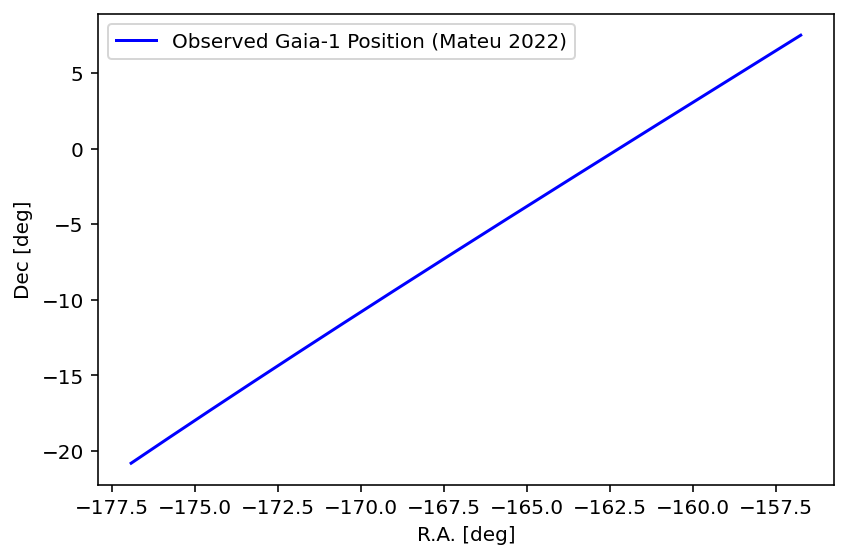

In [35]:
%matplotlib inline
#plt.figure(figsize=(8,6))
#plt.plot(c.ra.wrap_at(180*u.deg), c.dec, 'ro')
plt.plot(mwsts[name].track.ra.wrap_at(180*u.deg), mwsts[name].track.dec, 'b-', label='Observed Gaia-1 Position (Mateu 2022)')
plt.legend(loc='best')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
#plt.gca().set_aspect('equal')
plt.tight_layout()
plt.savefig('Gaia-1 Position', dpi=200)

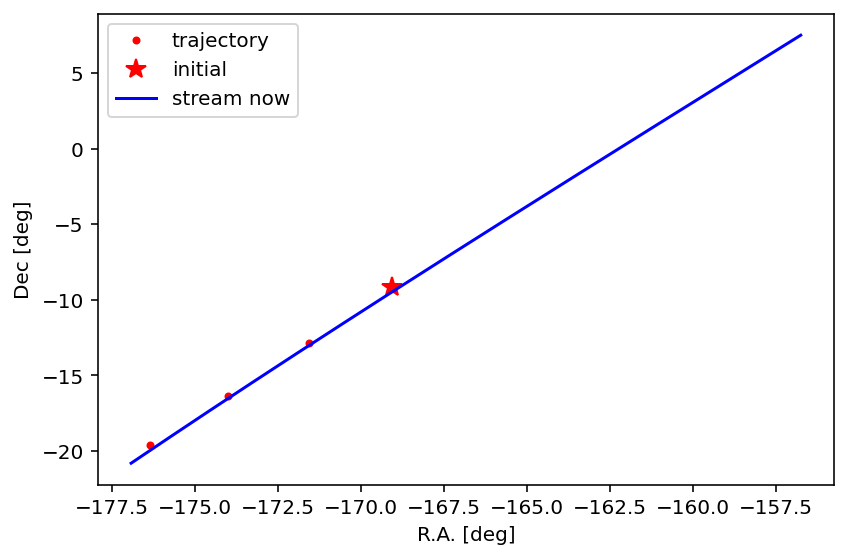

In [36]:
dt = 1*u.Myr
Nstep_foward = 3
orbit_foward = ham.integrate_orbit(w0, dt=dt, n_steps=Nstep_foward)
orbit_foward_icrs = orbit_foward.to_coord_frame(coord.ICRS())

plt.plot(orbit_foward_icrs.ra.wrap_at(180*u.deg), orbit_foward_icrs.dec, '.r', label='trajectory')
plt.plot(orbit_foward_icrs.ra.wrap_at(180*u.deg)[0], orbit_foward_icrs.dec[0], '*r', label='initial', ms=10)
plt.plot(mwsts[name].track.ra.wrap_at(180*u.deg), mwsts[name].track.dec, 'b-', label='stream now')
plt.legend(loc='best')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
plt.tight_layout()

In [37]:
w0_start = gd.PhaseSpacePosition(orbit_foward.pos[-1], orbit_foward.vel[-1])
Nstep = 9
orbit = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep)
orbit_sky = orbit.to_coord_frame(coord.ICRS())


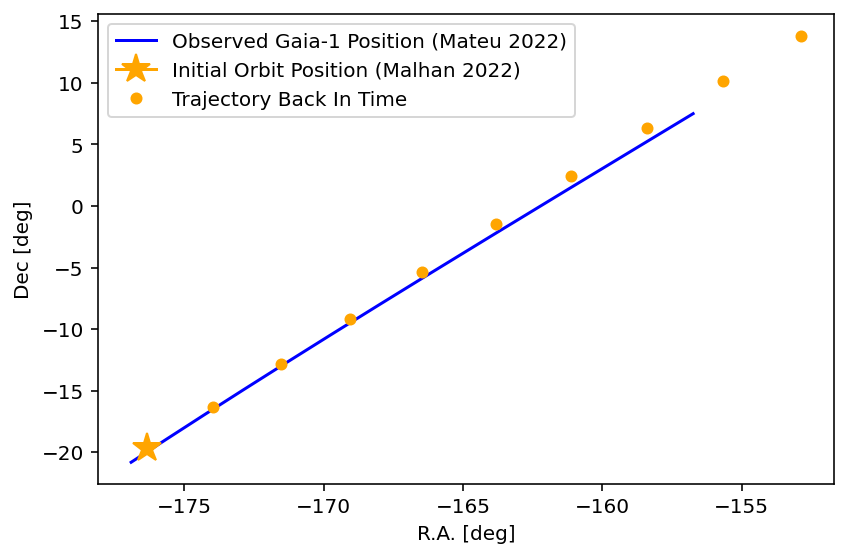

In [38]:
plt.plot(mwsts[name].track.ra.wrap_at(180*u.deg), mwsts[name].track.dec, 'b-', label='Observed Gaia-1 Position (Mateu 2022)')
plt.plot(orbit_sky.ra.wrap_at(180*u.deg)[0], orbit_sky.dec[0], markersize=15, color='orange', marker='*', label='Initial Orbit Position (Malhan 2022)')
plt.plot(orbit_sky.ra.wrap_at(180*u.deg), orbit_sky.dec, '.',color='orange',markersize=10, label='Trajectory Back In Time')
plt.legend(loc='best')
plt.xlabel('R.A. [deg]')
plt.ylabel('Dec [deg]')
plt.tight_layout()
plt.savefig('Gaia-1 Position with Malhan initial point.png', dpi=200)



In [39]:
#LONG ORBIT: going backwards in time
Nstep_long = 3000
orbit_long = ham.integrate_orbit(w0_start, dt=-dt, n_steps=Nstep_long)

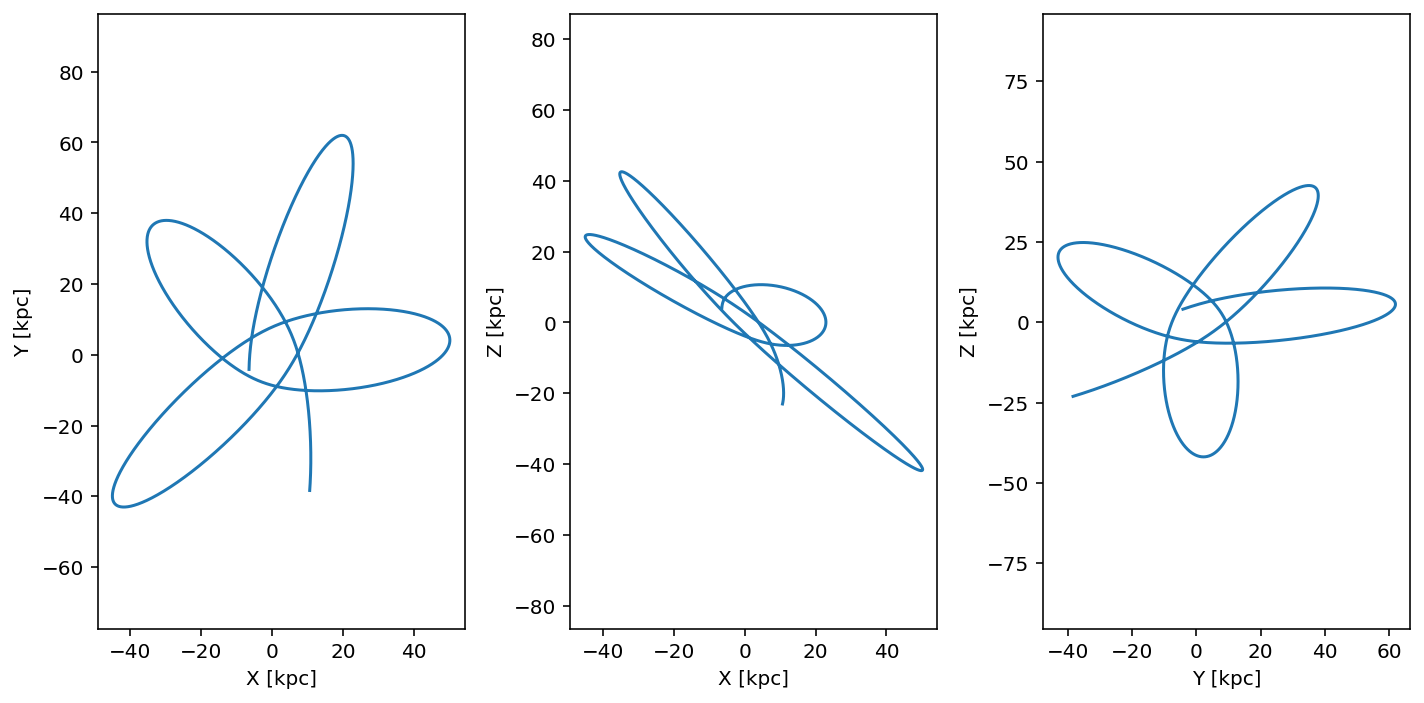

In [40]:
fig, ax = plt.subplots(1,3,figsize=(10,5))

plt.sca(ax[0])
plt.plot(orbit_long.pos.x, orbit_long.pos.y, '-')
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')

plt.sca(ax[1])
plt.plot(orbit_long.pos.x, orbit_long.pos.z, '-')
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('X [kpc]')
plt.ylabel('Z [kpc]')

plt.sca(ax[2])
plt.plot(orbit_long.pos.y, orbit_long.pos.z, '-')
plt.gca().set_aspect('equal', adjustable='datalim')
plt.xlabel('Y [kpc]')
plt.ylabel('Z [kpc]')

plt.tight_layout()

In [41]:
orbit_long.pericenter(), orbit_long.apocenter()

(<Quantity 8.22454575 kpc>, <Quantity 65.36532965 kpc>)

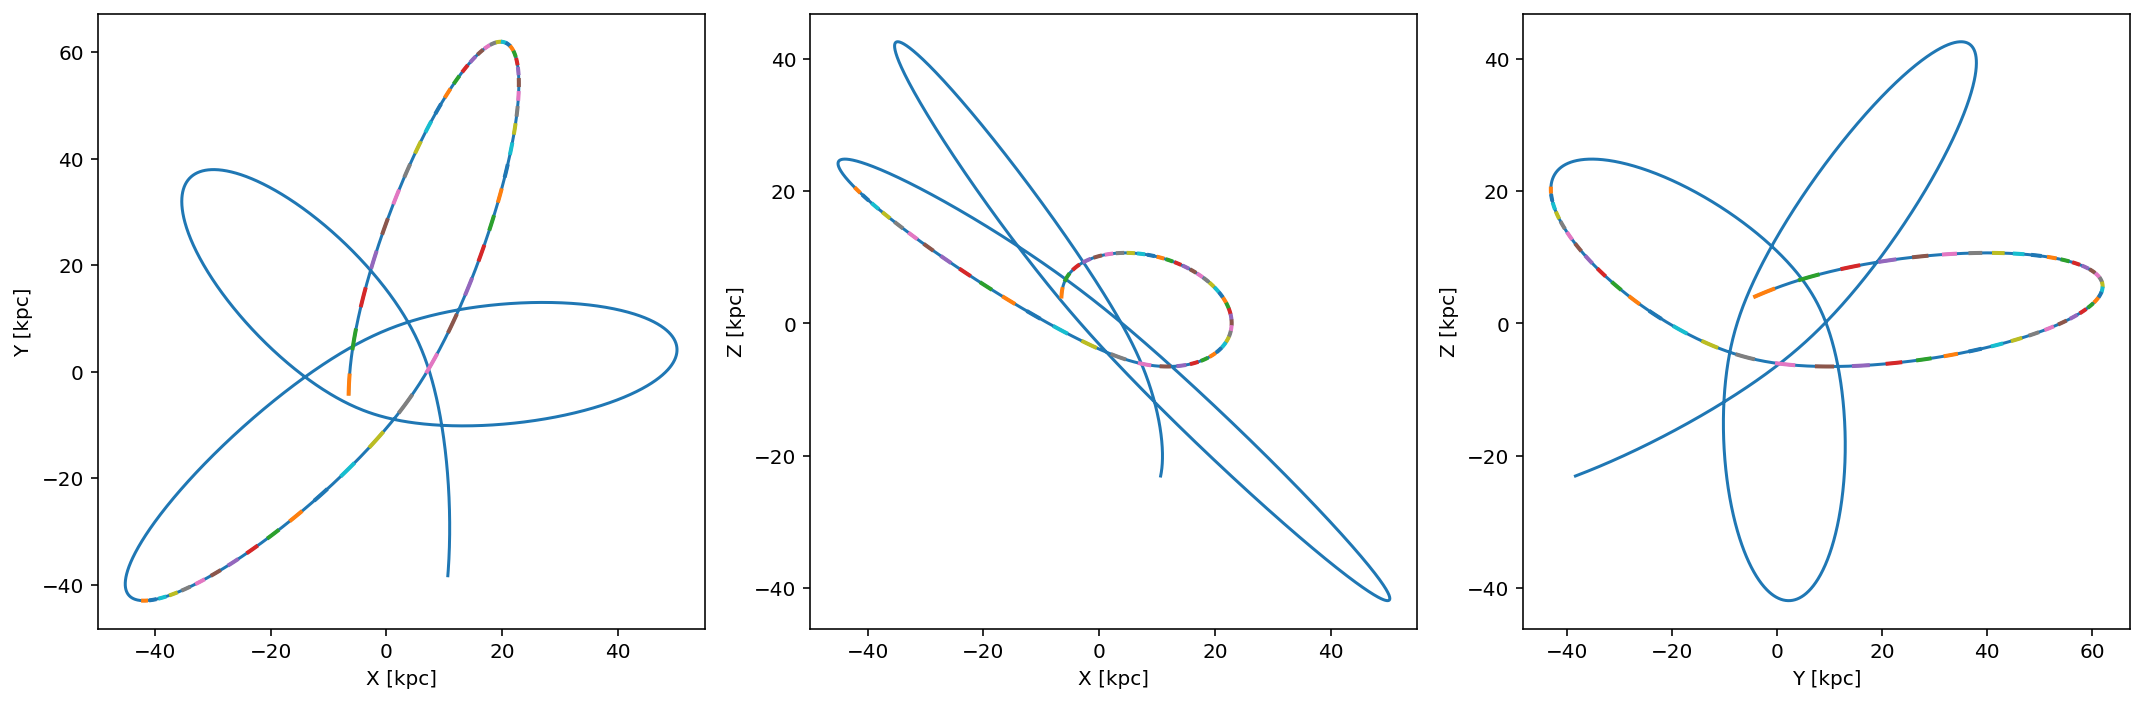

In [42]:
#Trajectory of the Stream in the Past

Nstep = 9 

fig, ax = plt.subplots(1,3,figsize=(15,5))

plt.sca(ax[0])
plt.plot(orbit_long.pos.x, orbit_long.pos.y, '-')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')

plt.sca(ax[1])
plt.plot(orbit_long.pos.x, orbit_long.pos.z, '-')
plt.xlabel('X [kpc]')
plt.ylabel('Z [kpc]')

plt.sca(ax[2])
plt.plot(orbit_long.pos.y, orbit_long.pos.z, '-')
plt.xlabel('Y [kpc]')
plt.ylabel('Z [kpc]')

#orbital segments of past positions of the stream
times = np.linspace(0,1000,51)*u.Myr
for tm in times:
    t = int((tm/dt).decompose())
    plt.sca(ax[0])
    plt.plot(orbit_long.pos.x[t:t+Nstep], orbit_long.pos.y[t:t+Nstep], '-', lw=2)
             #label='Stream in {:g}'.format(tm))
    
    plt.sca(ax[1])
    plt.plot(orbit_long.pos.x[t:t+Nstep], orbit_long.pos.z[t:t+Nstep], '-', lw=2)
             #label='Stream in {:g}'.format(tm))
    
    plt.sca(ax[2])
    plt.plot(orbit_long.pos.y[t:t+Nstep], orbit_long.pos.z[t:t+Nstep], '-', lw=2)
             #label='Stream in {:g}'.format(tm))

#plt.legend(fontsize='x-small', handlelength=0.7)

plt.tight_layout()

<IPython.core.display.Javascript object>


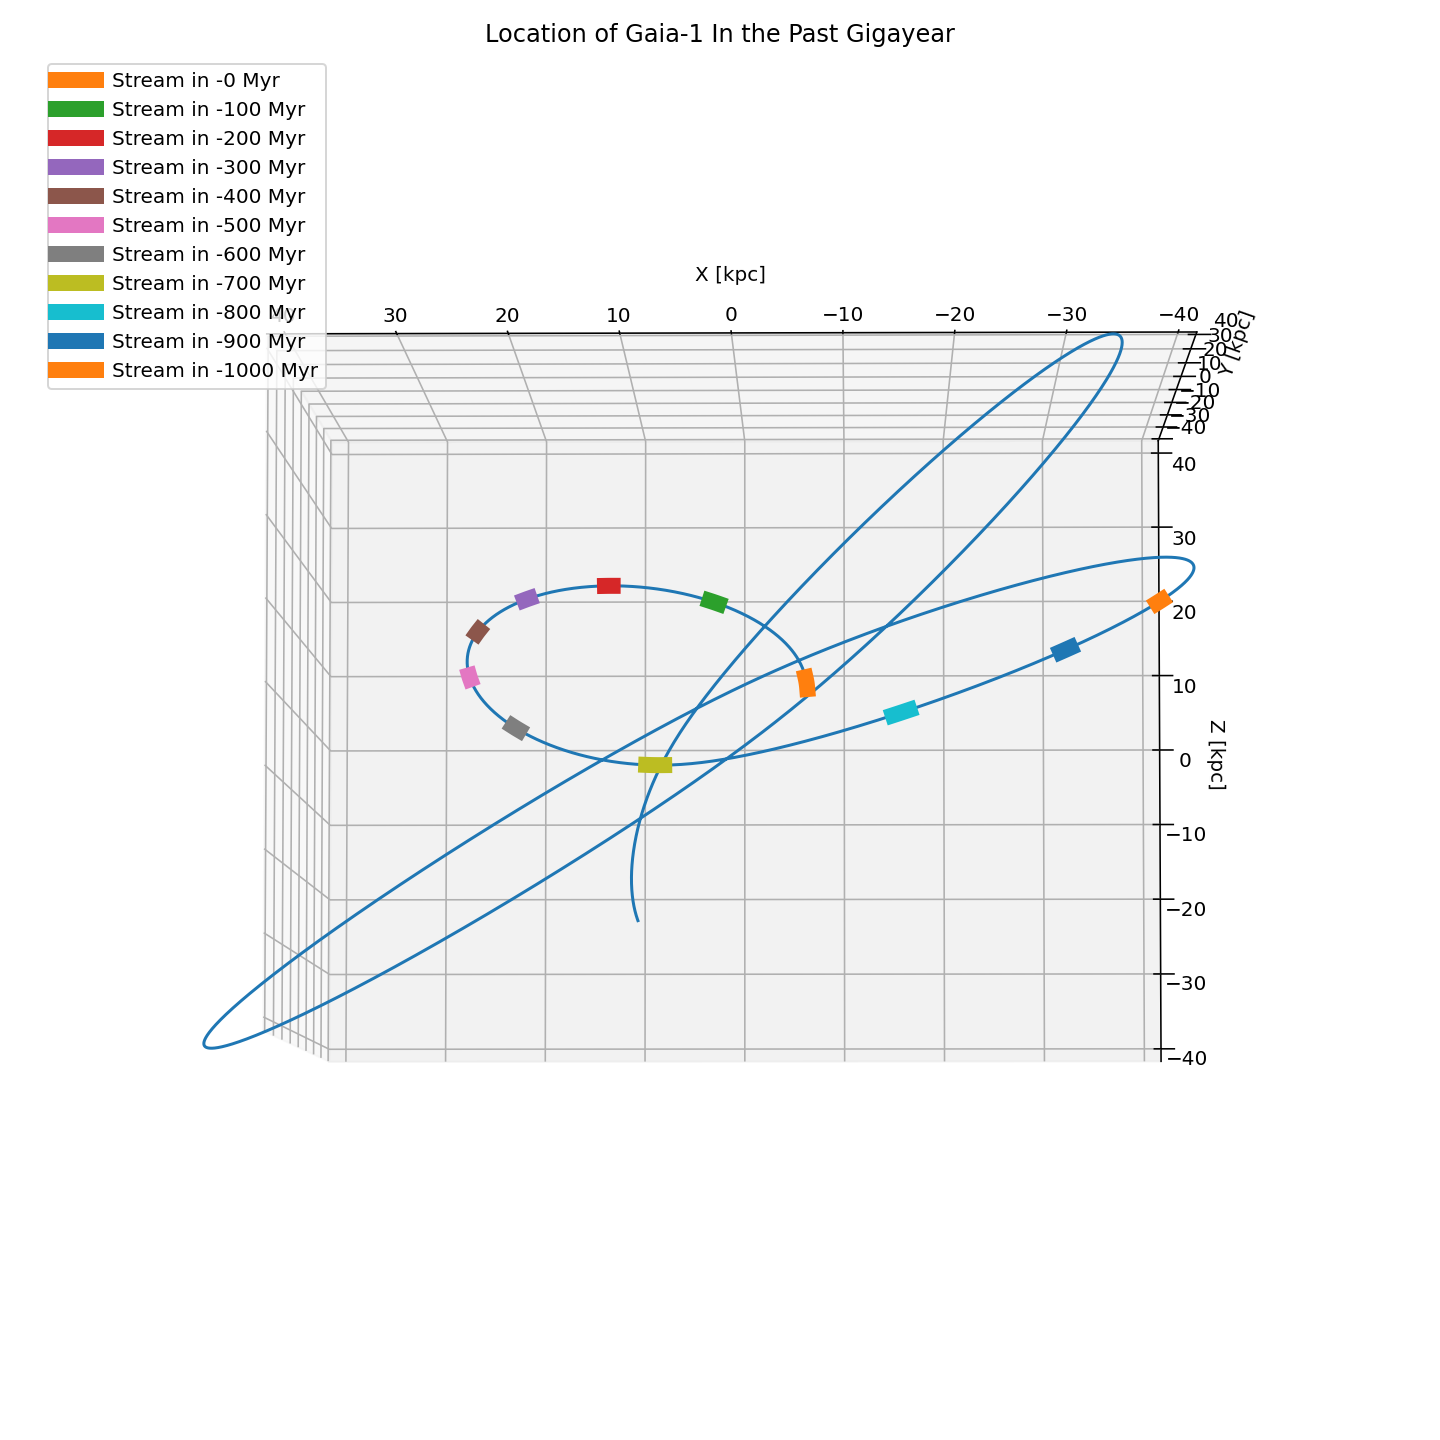

In [45]:
%matplotlib notebook
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

ax = plt.axes(projection='3d')

ax.plot(orbit_long.pos.x, orbit_long.pos.y, orbit_long.pos.z, '-')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')

#orbital segments of past positions of the stream
times = np.linspace(0,1000,11)*u.Myr
for tm in times:
    t = int((tm/dt).decompose())
    ax.plot(orbit_long.pos.x[t:t+Nstep], orbit_long.pos.y[t:t+Nstep],
             orbit_long.pos.z[t:t+Nstep], '-', lw=8,
             label='Stream in {:g}'.format(-tm))
plt.legend(loc='best')
ax.set_xlim(-40,40)
ax.set_ylim(-40,40)
ax.set_zlim(-40,40)
plt.title('Location of Gaia-1 In the Past Gigayear')
plt.tight_layout()
plt.savefig('Location of Stellar Stream in the Past Gigayear', transparent=True)

In [ ]:
t

In [ ]:
orbit_long.pos.x[t:t+Nstep]

In [ ]:
#Testing how to get change in position of subhalos 
c_subh0 = coord.Galactocentric(x=trot['x'][0]*u.kpc, y=trot['y'][0]*u.kpc, z=trot['z'][0]*u.kpc,
                         v_x=trot['vx'][0]*u.km/u.s, v_y=trot['vy'][0]*u.km/u.s,
                         v_z=trot['vz'][0]*u.km/u.s)
w0_subh0 = gd.PhaseSpacePosition(c_subh0.cartesian)
orbit_subh0 = ham.integrate_orbit(w0_subh0, dt=-dt, n_steps=Nstep)

len(orbit_subh0.pos.x[1:]) #Check if this is correct 


In [ ]:
len(orbit_long.pos.x[t:t+Nstep])


In [95]:
subh_orbits = []
Nstep_long=3000
for subh in range(len(ts['x'][ind_massive])): 
    #This calculates the position of the subhalos at a given time
    c_subh = coord.Galactocentric(x=ts['x'][ind_massive][subh]*u.kpc, y=ts['y'][ind_massive][subh]*u.kpc, 
                                  z=ts['z'][ind_massive][subh]*u.kpc,
                                  v_x=ts['vx'][ind_massive][subh]*u.km/u.s, 
                                  v_y=ts['vy'][ind_massive][subh]*u.km/u.s,
                                  v_z=ts['vz'][ind_massive][subh]*u.km/u.s)
    w0_subh = gd.PhaseSpacePosition(c_subh.cartesian)
    subh_orbits += [ham.integrate_orbit(w0_subh, dt=-dt, n_steps=Nstep_long)]
    

In [ ]:
subh_orbits[1].pos.x

In [96]:
#trot = Table(subhalos_z0[ind_massive])
N = len(subh_orbits[0].pos.x)

rot_orbits=np.zeros((len(ts['x'][ind_massive]), len(subh_orbits[1].pos.x), 3))

for j, subh in enumerate(subh_orbits):
    for i in range(N):
        temp_vec = np.array([subh.pos.x[i].value, subh.pos.y[i].value, subh.pos.z[i].value])
        rot_vec = np.matmul(R, temp_vec)

        rot_orbits[j][i][0] = rot_vec[0]#*u.kpc
        rot_orbits[j][i][1] = rot_vec[1]#*u.kpc
        rot_orbits[j][i][2] = rot_vec[2]#*u.kpc

In [ ]:
len(rot_orbits)

In [ ]:
#%matplotlib notebook
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

ax = plt.axes(projection='3d')

ax.scatter(rot_orbits[1,:,0],rot_orbits[1,:,1], rot_orbits[1,:,2], '.r', s=5)
ax.scatter(subh_orbits[1].pos.x, subh_orbits[1].pos.y, subh_orbits[1].pos.z)

In [ ]:
print(rot_orbits.shape)

In [ ]:
print(trot['x'][0],trot['vx'][0] )

In [ ]:
print(ts['x'][0], ts['vx'][0])

In [ ]:
plt.plot(subh_orbits[1].pos.x, subh_orbits[1].pos.y)

In [ ]:
Nstep=9
times = np.linspace(0,1000,21)*u.Myr
#times_new = times[1:]
dt = 1*u.Myr

data_all = pd.DataFrame()
for st_time in times:
    t = int((st_time/dt).decompose())
    print(st_time)
    data_new = {'Gaia-1':[st_time]}
    data_temp = pd.DataFrame(data=data_new)
    for subh in range(len(trot['x'])): #subh stands for individual subhalo
        dist_x = orbit_long.pos.x[t:t+Nstep] - rot_orbits[subh,t,0]*u.kpc
        dist_y = orbit_long.pos.y[t:t+Nstep] - rot_orbits[subh,t,1]*u.kpc
        dist_z = orbit_long.pos.z[t:t+Nstep] - rot_orbits[subh,t,2]*u.kpc
        tot_dist = np.sqrt((dist_x**2) + (dist_y**2) + (dist_z**2))
        min_dist = np.amin(tot_dist)
        data_temp['Subhalo_'+ str(subh)+ ' (kpc)'] = [min_dist.value]
    data_all = data_all.append(data_temp, ignore_index=True)

In [ ]:
data_all.to_csv('20220805_Complete_Data_Subhalo_to_Gaia1_Distance_Over_Time.csv',index=False)


In [70]:
data_all_temp = pd.read_csv('20220805_Complete_Data_Subhalo_to_Gaia1_Distance_Over_Time.csv')

In [73]:
data_all_temp = data_all_temp.iloc[: , 1:]
data_all_temp;

In [74]:
data_all_temp

,Subhalo_0 (kpc),Subhalo_1 (kpc),Subhalo_2 (kpc),Subhalo_3 (kpc),Subhalo_4 (kpc),Subhalo_5 (kpc),Subhalo_6 (kpc),Subhalo_7 (kpc),Subhalo_8 (kpc),Subhalo_9 (kpc),...,Subhalo_1062 (kpc),Subhalo_1063 (kpc),Subhalo_1064 (kpc),Subhalo_1065 (kpc),Subhalo_1066 (kpc),Subhalo_1067 (kpc),Subhalo_1068 (kpc),Subhalo_1069 (kpc),Subhalo_1070 (kpc),Subhalo_1071 (kpc)
0,99.302099,119.829695,279.006604,181.183819,95.400041,296.101789,122.219409,167.841217,204.347727,142.108145,...,153.965280,111.513122,117.626766,125.881360,125.717423,147.325103,81.782319,226.767360,203.283334,121.271600
1,105.094754,136.373716,272.491471,183.411337,103.117152,309.640474,134.078821,158.199625,202.447687,166.137224,...,148.328858,119.765968,138.813493,129.909181,115.401712,165.846887,71.435751,214.138023,209.258929,138.118004
2,103.895287,146.164747,271.131804,180.048087,109.490139,320.034643,141.782779,155.412378,203.901471,185.107155,...,140.483258,121.815014,157.081739,134.236771,111.296532,178.726099,66.776376,204.656858,213.413659,150.972475
3,97.265055,151.250792,273.404658,173.240938,113.317546,328.124935,146.789795,156.191824,206.189382,199.341664,...,132.060964,119.474341,171.542739,136.969185,110.022454,187.813632,64.601877,197.445771,214.451252,159.506397
4,86.107117,152.728769,278.373570,163.695517,114.638373,334.315374,149.439620,158.657066,208.181836,209.675706,...,123.184727,113.657322,182.657198,137.565664,110.129262,194.056619,63.377825,191.776755,212.554149,164.202741
5,71.227265,151.243343,285.512116,151.703755,113.591862,338.803229,149.874576,161.530193,209.386902,216.622789,...,113.899773,104.967041,190.783211,135.760168,110.735957,197.975534,63.160416,187.202483,207.888172,165.371326
6,54.310270,147.166359,294.507932,137.222067,110.359468,341.703317,148.009436,163.966094,209.552398,220.508824,...,104.308468,94.007839,196.163698,131.357807,111.142632,199.923466,65.339215,183.445940,200.543155,163.188412
7,38.716383,140.888178,304.986937,120.523865,105.196791,342.950859,144.058225,165.358355,208.537111,221.474406,...,94.623593,81.473456,198.959561,124.161683,110.873084,199.983987,70.422826,180.346926,190.544817,157.688093
8,30.651720,133.044802,316.957638,101.692299,98.490873,342.689268,138.072505,165.227559,206.258074,219.469310,...,85.222831,69.012466,199.229169,113.679163,109.577185,198.573667,76.279325,177.704887,177.702091,148.642125
9,36.421174,124.219006,330.497554,80.860676,90.663274,341.006795,130.085210,162.994867,202.667126,214.864998,...,76.709560,58.885831,196.807885,99.763777,106.970052,196.018410,81.662122,175.623975,161.932478,136.291406


In [76]:
min_dist_subhalos_to_str = data_all_temp.min()

In [84]:
present_pos=data_all_temp.iloc[0]
present_pos

Subhalo_0 (kpc)        99.302099
Subhalo_1 (kpc)       119.829695
Subhalo_2 (kpc)       279.006604
Subhalo_3 (kpc)       181.183819
Subhalo_4 (kpc)        95.400041
                         ...    
Subhalo_1067 (kpc)    147.325103
Subhalo_1068 (kpc)     81.782319
Subhalo_1069 (kpc)    226.767360
Subhalo_1070 (kpc)    203.283334
Subhalo_1071 (kpc)    121.271600
Name: 0, Length: 1072, dtype: float64

<IPython.core.display.Javascript object>


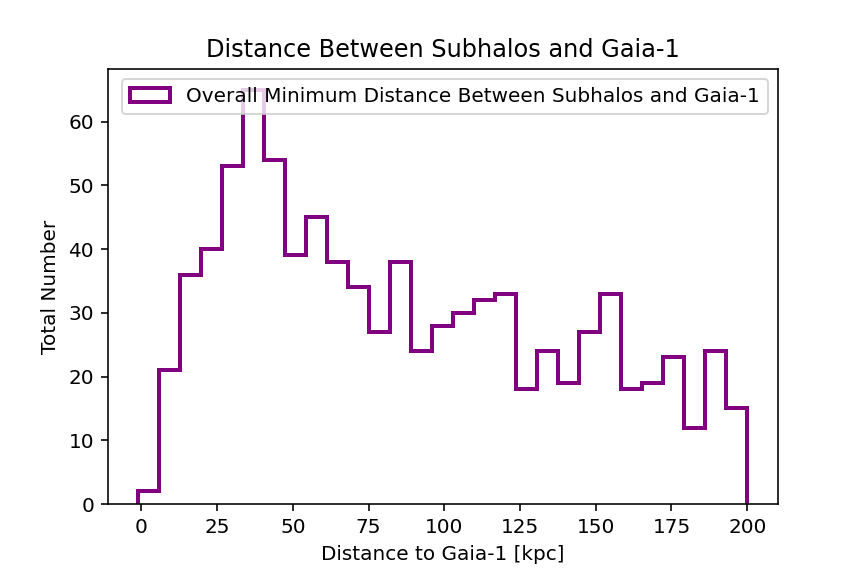

In [146]:
plt.figure()
#plt.hist(present_pos, bins=np.linspace(-1,200,50), color='brown', alpha=0.6, label='Present Minimum Distance Between Subhalos and Gaia-1');  
plt.hist(min_dist_subhalos_to_str,bins=np.linspace(-1,200,30), color='purple', histtype='step', linewidth=2, label='Overall Minimum Distance Between Subhalos and Gaia-1');
plt.title('Distance Between Subhalos and Gaia-1') 
plt.xlabel('Distance to Gaia-1 [kpc]')
plt.ylabel('Total Number')
plt.legend(loc='best')
plt.savefig('Distance Between Subhalos and Gaia-1 (Present)', dpi=200)


<IPython.core.display.Javascript object>


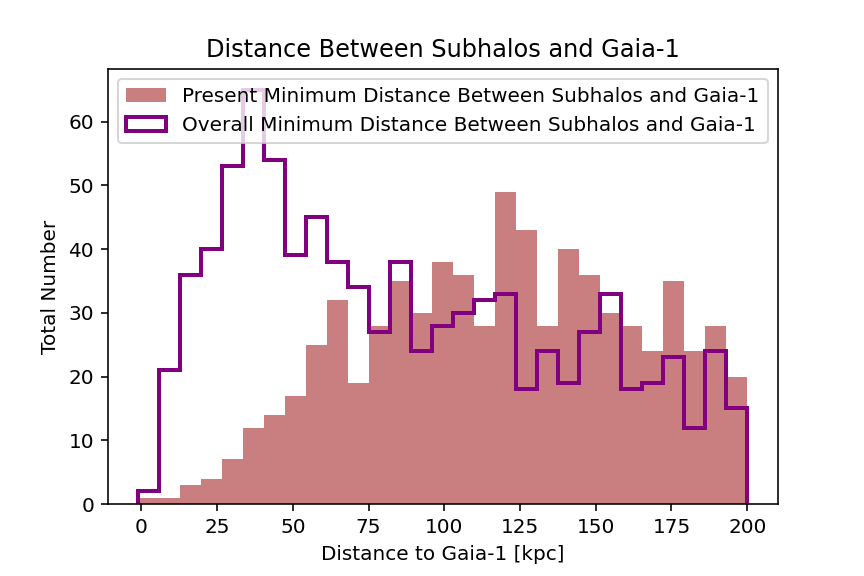

In [147]:
plt.figure()
plt.hist(present_pos, bins=np.linspace(-1,200,30), color='brown', alpha=0.6, label='Present Minimum Distance Between Subhalos and Gaia-1');  
plt.hist(min_dist_subhalos_to_str,bins=np.linspace(-1,200,30), color='purple', histtype='step', linewidth=2, label='Overall Minimum Distance Between Subhalos and Gaia-1');
plt.title('Distance Between Subhalos and Gaia-1') 
plt.xlabel('Distance to Gaia-1 [kpc]')
plt.ylabel('Total Number')
plt.legend(loc='best')
plt.savefig('Distance Between Subhalos and Gaia-1 (Overall and Present)', dpi=200)


In [77]:
data_all_temp.min(axis=1)

0      3.389149
1      5.843874
2     14.709698
3      9.175982
4     14.076522
5     13.900564
6     13.826839
7     12.193007
8     11.043096
9      6.143776
10     6.076528
11    10.438179
12    12.618491
13    10.794773
14    11.883143
15    10.915009
16    11.529217
17    13.176040
18    10.483472
19    13.974262
20    12.984627
dtype: float64

In [ ]:
data_all_temp.idxmin(axis=1)

In [ ]:
data_all_temp['Subhalo_976 (kpc)']

In [ ]:
trot

In [ ]:
trot[396]['mvir']/h

In [ ]:
data_all['Subhalo_60 (kpc)']

<IPython.core.display.Javascript object>


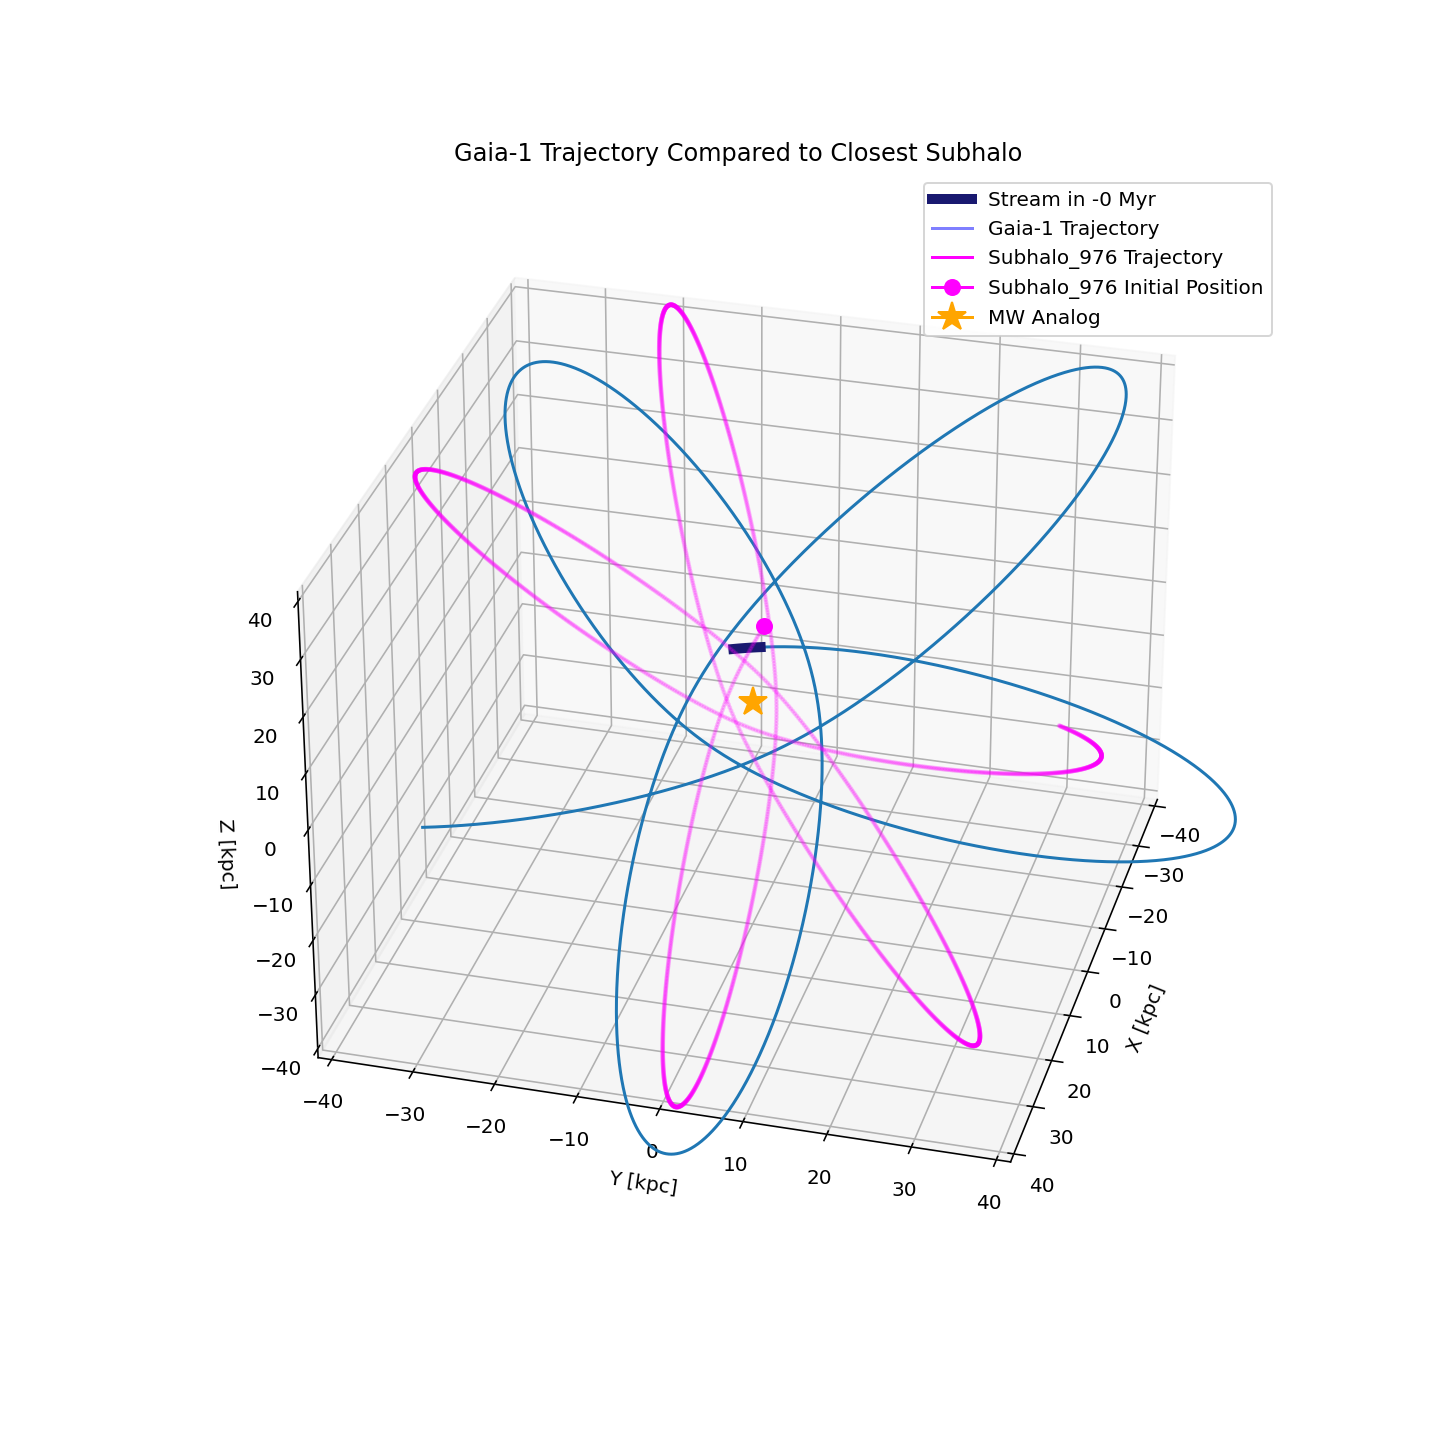

In [145]:
%matplotlib notebook
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(10)

ax = plt.axes(projection='3d')

ax.plot(orbit_long.pos.x, orbit_long.pos.y, orbit_long.pos.z, '-')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')

#orbital segments of past positions of the stream
times = np.linspace(0,1000,1)*u.Myr
for tm in times:
    t = int((tm/dt).decompose())
    ax.plot(orbit_long.pos.x[t:t+Nstep], orbit_long.pos.y[t:t+Nstep],
             orbit_long.pos.z[t:t+Nstep], '-', color = 'midnightblue', lw=5,
             label='Stream in {:g}'.format(-tm))
    
ax.scatter(rot_orbits[976,:,0], rot_orbits[976,:,1], rot_orbits[976,:,2], color='magenta', 
           s=2, alpha=0.2)
plt.plot(1000,1000,1000, '-',color='blue',alpha=0.5, label='Gaia-1 Trajectory',
        ms=20)
plt.plot(1000,1000,1000, '-', color='magenta', ms=30, label='Subhalo_976 Trajectory')
plt.plot(rot_orbits[976,0,0], rot_orbits[976,0,1], rot_orbits[976,0,2], marker='.', color='magenta',
        ms=15, label='Subhalo_976 Initial Position')
plt.plot(0,0,0, marker='*',color='orange',ms=15, label='MW Analog')

plt.legend(loc='best')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')
plt.legend(loc='best')
plt.title('Gaia-1 Trajectory Compared to Closest Subhalo')
ax.set_xlim(-40,40)
ax.set_ylim(-40,40)
ax.set_zlim(-40,40)
ax.view_init(elev=30, azim=15)


plt.savefig('Gaia-1 Trajectory Over 1 Giga-year', transparent=True, dpi=200)

In [ ]:
mwsts['Gaia-1-I21'].length.deg